Нужно понять, стали ли мы больше зарабатывать с пользователя или нет.

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [15]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
import requests
import urllib
import json
from urllib.parse import urlencode

*Посмотрим на данные, приведем столбец 'value' к числовому виду, отберем тестовую и контрольную выборку, убедимся в одинаковом размере выборок*

In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/FPMcY4_9kTUpNg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
df = pd.read_csv(download_url, sep = ';')
df.head(2)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control


In [6]:
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [7]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [8]:
df.value = df.value.apply(lambda x: x.replace(',', '.'))

In [9]:
df.head(1)

,Unnamed: 0,value,experimentVariant
0,1,10.3804953740268,Control


In [10]:
df = df.astype({'value': 'float'})
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [11]:
df_control = df.query('experimentVariant=="Control"')
df_test = df.query('experimentVariant=="Treatment"')
df_control.shape, df_test.shape

((500, 3), (500, 3))

**Проведем t-тест на определение значимой разницы между тестовой и контрольной выборками и найдем p-value**

In [12]:
statistics_tt, p_tt = scipy.stats.ttest_ind(df_control.value, df_test.value)
p_tt

0.038437593613498765

**Проведем U-тест и определим p-value**

In [13]:
statistics_U, p_U = scipy.stats.mannwhitneyu(df_control.value, df_test.value)
p_U

0.8592148582485579

**Используем любезно предоставленную кастомную функцию для опрелеления p-value бутстрап методом**

In [16]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = scipy.stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = scipy.stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

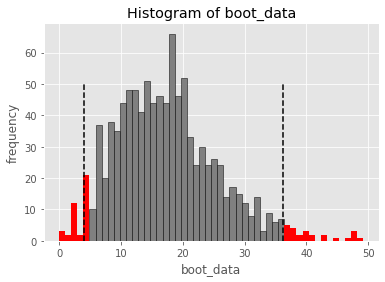

In [17]:
booted_data = get_bootstrap(df_test.value, df_control.value) # в результате хранится разница двух распределений, ДИ и pvalue

In [18]:
booted_data["p_value"] # альфа

0.03702770625609134

Для использования t-критерия Стьюдента требуется соблюдение следующих условий:
1. Дисперсии внутри наших групп должны быть примерно одинаковы
(Проверить можно с помощью критерия Левена и критерия Фишера)
2. Нормальности обеих выборок.
(Проверить можно с помощью тестов Колмогорова-Смирнова, Шапиро-Уилка)

*проверка на нормальность распределения. Тест Шапиро.*

In [19]:
scipy.stats.shapiro(df_test.value), scipy.stats.shapiro(df_control.value)

(ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43),
 ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963))

*Как мы видим, в тестовой выборке распределение не является нормальным.*

*Проверка на одинаковость дисперсий. Тест Левена*

In [66]:
scipy.stats.levene(df_test.value, df_control.value)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

*Значение меньше 0.05 (в данном случае принимаем данную границы) показывает, что выборки не содержат похожие дисперсии внутри групп.*

**Таким образом, ввиду того, что условия нормальности распределения значений в выборках, а также равность дисперсий не соблюдаются, t-критерий в данном случае не применим.**

**В данном задании не требуется оценить какой-либо конктретный параметр выборки (среднее, медиана, конкретный перцентиль), а требуется определить значимо ли различаются распределения. Соответственно, в данном случае отсутствует необходимость в применении бутстрап метода**

*Если распределение признака отличается от нормального, можно использовать
непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в
ранговую шкалу после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот
критерий менее чувствителен к экстремальным отклонениям от нормальности и
наличию выбросов. С учетом результатов теста на нормальность и теста на схожесть дисперсий в данной случае лучше использовать критерий оценки Манна-Уитни*

**Ввиду того, что p-value по критерию Манна_Уитни равен 0.86, что больше 0.05 (в данном задании примем данную границу), соответственно, нулевую гипотезу не отвергаем. Тестовая и контрольная выборки значимо не отличаются.**